In [1]:
!pip install wordcloud
!pip install gensim

In [2]:
import os.path

DATASET = 'OSCE/dor_toracica_x_infarto'

# MODEL = 'bert-sentence-NLI'
# MODEL = 'biobert-sentence-NLI'
# MODEL = 'envoy-sentence-NLI'

# MODEL = 'bert-sentence-STS'
# MODEL = 'biobert-sentence-STS'
MODEL = 'envoy-sentence-STS'

# MODEL = 'bert-base-cased'
# MODEL = 'sts-biobert-base-cased'
# MODEL = 'sts-envoy'
# MODEL = 'all-mpnet-base-v2' # BEST PRE-TRAINED MODEL FROM SENTENCE_TRANFORMERS

epoch = 'best/'

TXT_INPUT_FILE = '../datasets/' + DATASET + '/respostas_ingles.txt'
TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_2/' + DATASET + '/' + MODEL + '/' + epoch
# TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_2/' + DATASET + '/' + MODEL + '/'

with open(TXT_INPUT_FILE) as f:
    data_samples = f.readlines()

IMG_OUTPUT_PATH = 'imgs/'
if not os.path.exists(IMG_OUTPUT_PATH): os.mkdir(IMG_OUTPUT_PATH)

IMG_OUTPUT_PATH += DATASET + '/'
if not os.path.exists(IMG_OUTPUT_PATH): os.mkdir(IMG_OUTPUT_PATH)
    
IMG_OUTPUT_PATH += MODEL + '/' + epoch
# IMG_OUTPUT_PATH += MODEL + '/'
if not os.path.exists(IMG_OUTPUT_PATH): os.makedirs(IMG_OUTPUT_PATH, exist_ok=True)

# Etapa 1: Produção dos Embeddings de Sentença

In [3]:
import pandas as pd

embeddings_dataframe = pd.read_csv(TSV_INPUT_PATH + 'word_embeddings.tsv', sep='\t',header=None)
sentences_dataframe = pd.read_csv(TSV_INPUT_PATH + 'labels.tsv', sep='\t',header=None)

print('Sentenças: ')
print(sentences_dataframe, '\n\n')
print('Dimensão dos Embeddings: ', embeddings_dataframe.shape)


embeddings_numpy = embeddings_dataframe.to_numpy()
sentences_numpy = sentences_dataframe.to_numpy()
# print(sentences_numpy)
X_embeddings = embeddings_numpy[:, :-1]

sentences = []
# print(len(X_embeddings))
for x in range(len(X_embeddings)):
    sentences.append(x)

Sentenças: 
                                                    0
0   Acute myocardial infarction is usually manifes...
1   It is when the cardiac muscle suffers ischemia...
2   Acute infarction can have an ECG representatio...
3   There are different types of infarctions, the ...
4   Typical presentation: acute thoracic, more fre...
..                                                ...
76  AMI is the result of rupture of the atheroscle...
77  AMI is an ischemic disease that affects the co...
78  There are infarcts with ST elevation and witho...
79  It can be with ST elevation or without ST elev...
80  CV risk factors: DM, AHT, Obesity, Smoking, Ag...

[81 rows x 1 columns] 


Dimensão dos Embeddings:  (81, 769)


### Visualização em 2d dos Embeddings de Sentença

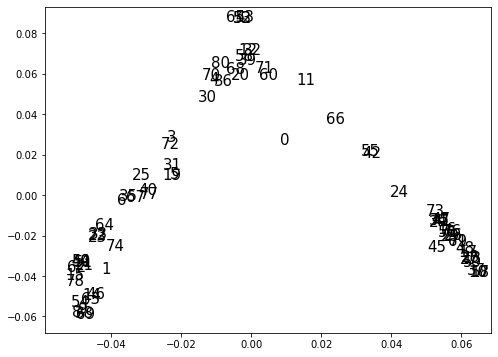

In [4]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(X_embeddings)

x = X_2d[:,0]
y = X_2d[:,1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='white', s=30)

for i, sentence in enumerate(sentences):
    plt.annotate(sentence, (x[i], y[i]), fontsize=15)

plt.savefig(IMG_OUTPUT_PATH + 'sentence-embeddings')

# Etapa 2: Clustering

In [5]:
from sklearn.cluster import AgglomerativeClustering

clusterings = []
n_clusters = []
colors = []

cutoff_thresholds = [20, 15, 14, 11, 8.5, 3, 1] #bert-sentence-STS
# cutoff_thresholds = [6, 5, 4, 3, 2, 1.5, 1] # envoy
# cutoff_thresholds = [2, 1, 0.9, 0.7, 0.5, 0.3, 0.1]  # all-mpnet-base-v2
# cutoff_thresholds = [30, 27, 26, 25, 24, 23, 22]  # envoy-sentence-NLI

for threshold in cutoff_thresholds:
    clustering = AgglomerativeClustering(linkage='ward', distance_threshold=threshold, n_clusters=None)
    clustering = clustering.fit(X_embeddings)
    clusterings.append(clustering)
    
    n_clusters.append(clustering.n_clusters_)
    selected_colors = [plt.cm.nipy_spectral(label / 10.) for label in clustering.labels_]

    colors.append(selected_colors)

### Plot a Clustering run result  

In [6]:
chosen_clustering = 1

print('Limiares: ', cutoff_thresholds)
print('Clusters: ', n_clusters)

with open(IMG_OUTPUT_PATH + '/notes.txt', "w") as file:
    print('cutoff_thresholds: '+str(cutoff_thresholds), file=file)   
    print('n_clusters: '+str(n_clusters), file=file)   
    print('chosen_clustering: '+str(chosen_clustering), file=file)   

Limiares:  [20, 15, 14, 11, 8.5, 3, 1]
Clusters:  [2, 3, 3, 4, 5, 24, 79]


Threshold:  15
Number of Resulting clusters 3


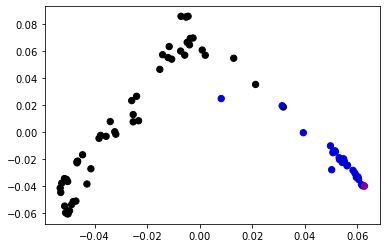

In [7]:
plt.figure()
# plt.figure(figsize=(8, 6))

plt.scatter(x, y, color=colors[chosen_clustering], s=40, cmap='hsv_r')

plt.savefig(IMG_OUTPUT_PATH + 'clusters')

print('Threshold: ', cutoff_thresholds[chosen_clustering])
print('Number of Resulting clusters',  n_clusters[chosen_clustering])

### Plot dendrogram sample

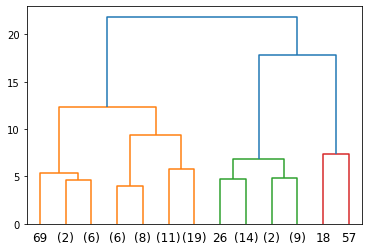

In [8]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.figure()
# plt.figure(figsize=(8, 6))

counts = np.zeros(clusterings[chosen_clustering].children_.shape[0])
n_samples = len(clusterings[chosen_clustering].labels_)
for i, merge in enumerate(clusterings[chosen_clustering].children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clusterings[chosen_clustering].children_, clusterings[chosen_clustering].distances_, counts]).astype(float)

dendrogram(linkage_matrix, truncate_mode='level', p=3)

plt.savefig(IMG_OUTPUT_PATH + 'dendrograma')


# Etapa 3: Topic Recognition

AgglomerativeClustering(distance_threshold=20, n_clusters=None)
Quantidade de clusters resultantes:  2
Coerência:  0.6904971616697191
Coerência por Tópico:  [0.9000265412246214, 0.48096778211481683]


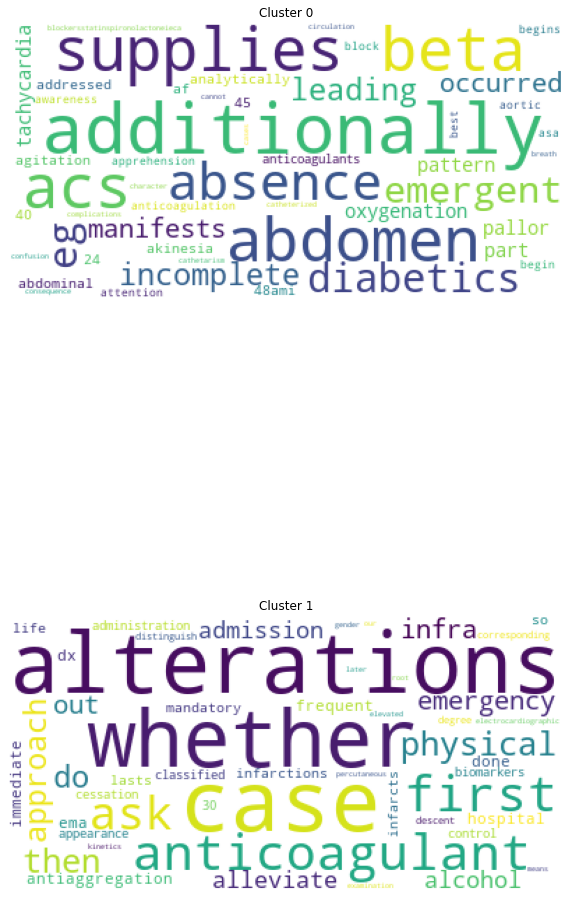

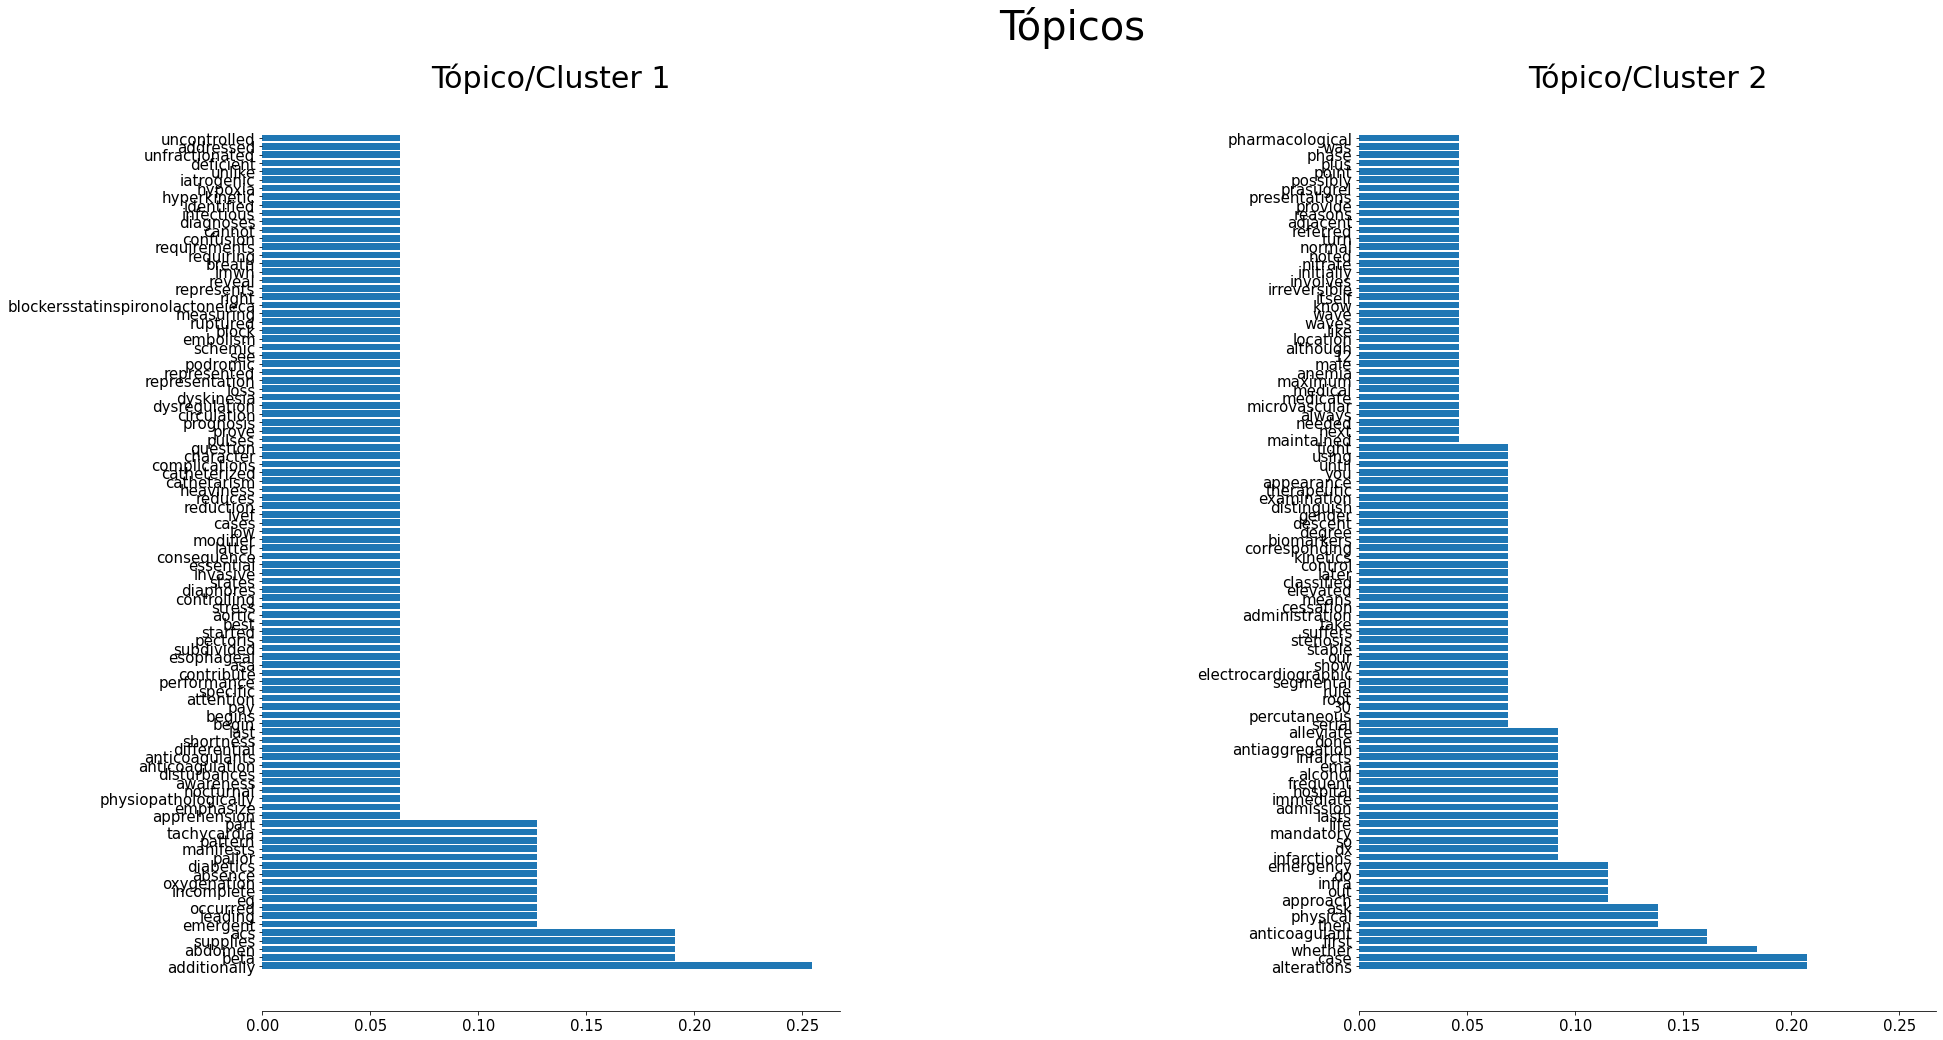

----------------------


AgglomerativeClustering(distance_threshold=15, n_clusters=None)
Quantidade de clusters resultantes:  3
Coerência:  0.4890102476503099
Coerência por Tópico:  [0.4560860004524861, 0.5824493254604736, 0.42849541703797006]


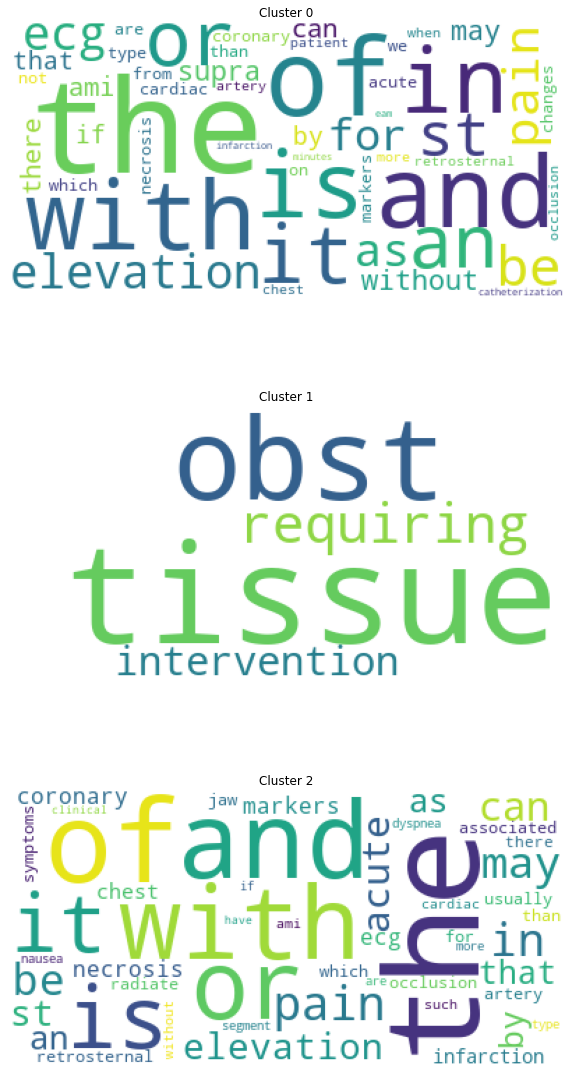

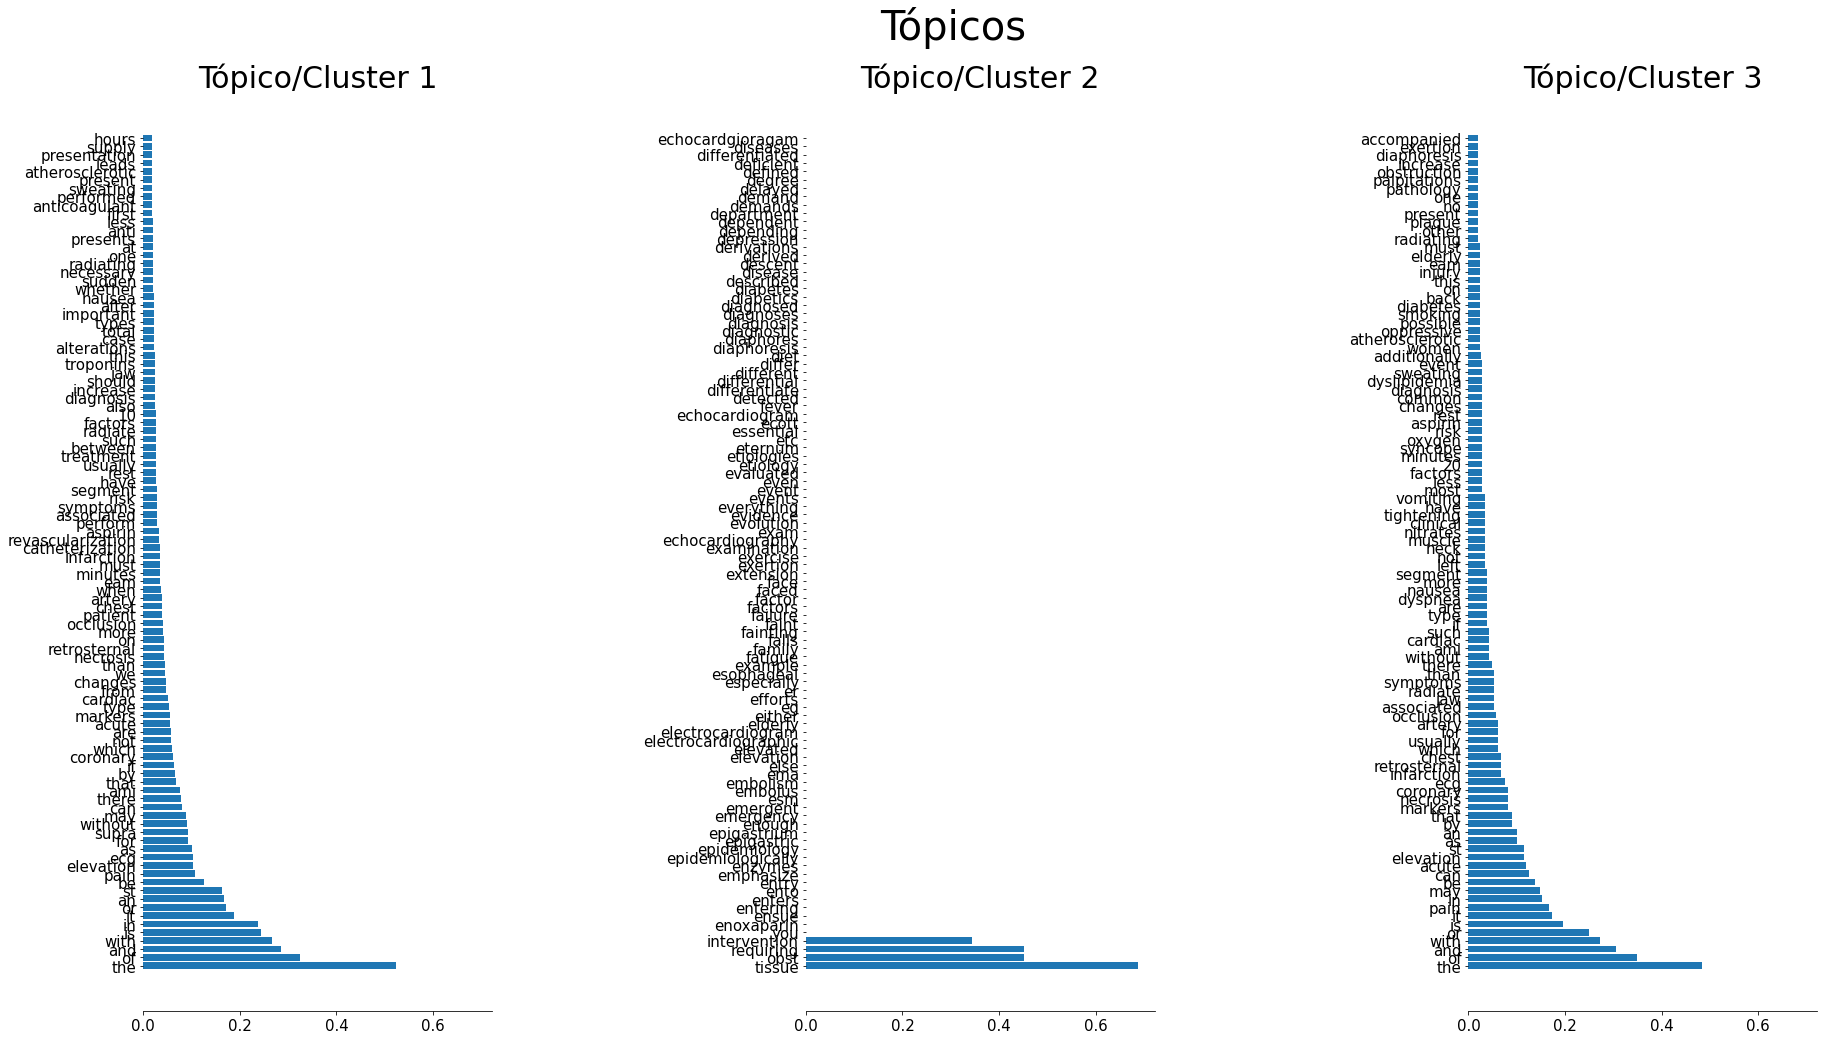

----------------------


AgglomerativeClustering(distance_threshold=14, n_clusters=None)
Quantidade de clusters resultantes:  3
Coerência:  0.4890102476503099
Coerência por Tópico:  [0.4560860004524861, 0.5824493254604736, 0.42849541703797006]


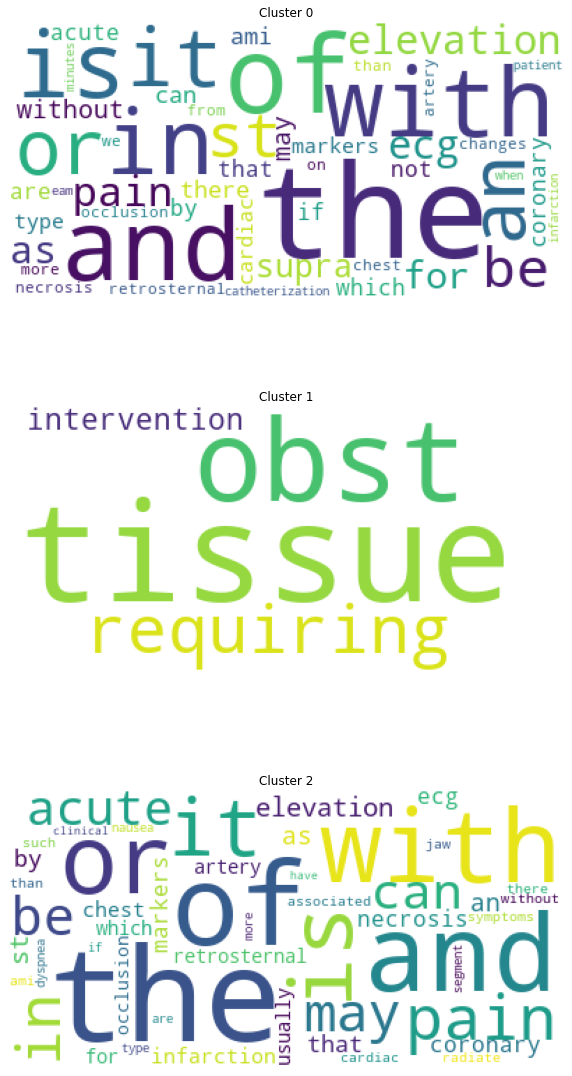

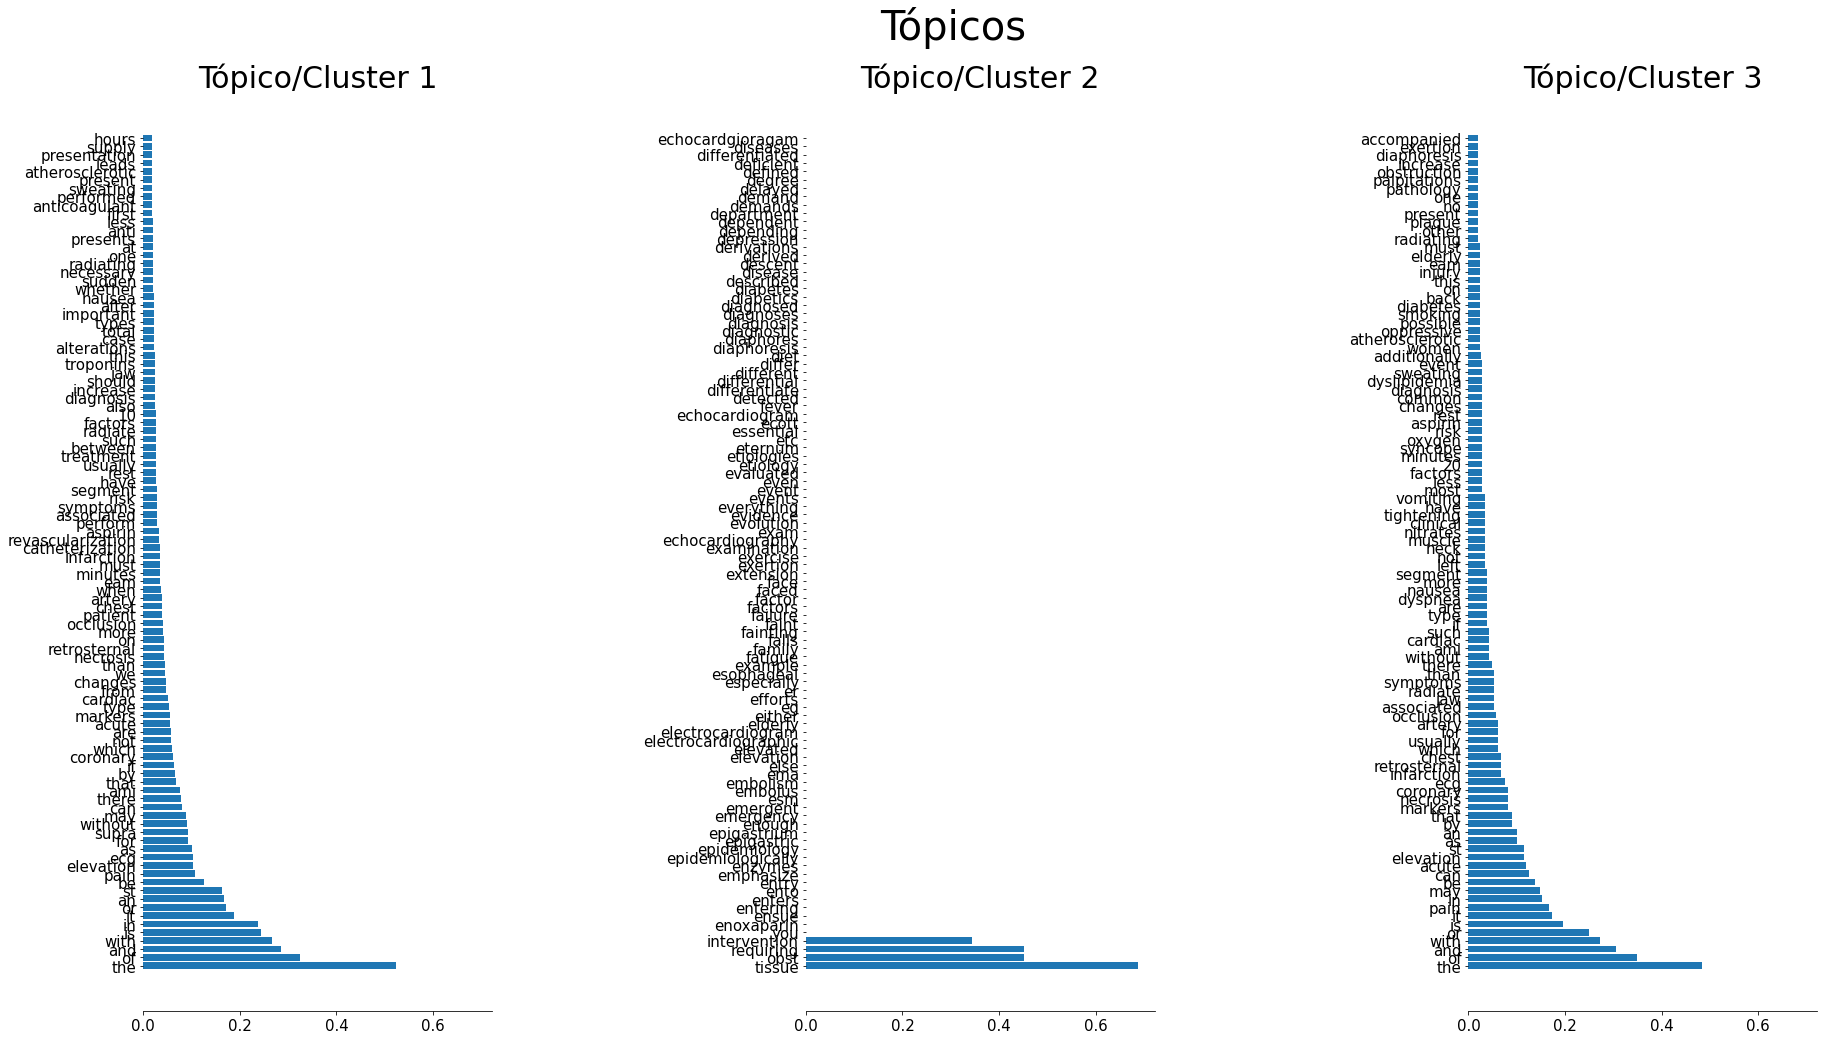

----------------------


AgglomerativeClustering(distance_threshold=11, n_clusters=None)
Quantidade de clusters resultantes:  4
Coerência:  0.40687745449120905
Coerência por Tópico:  [0.3947855852075499, 0.5253289643479593, 0.375644203133566, 0.331751065275761]


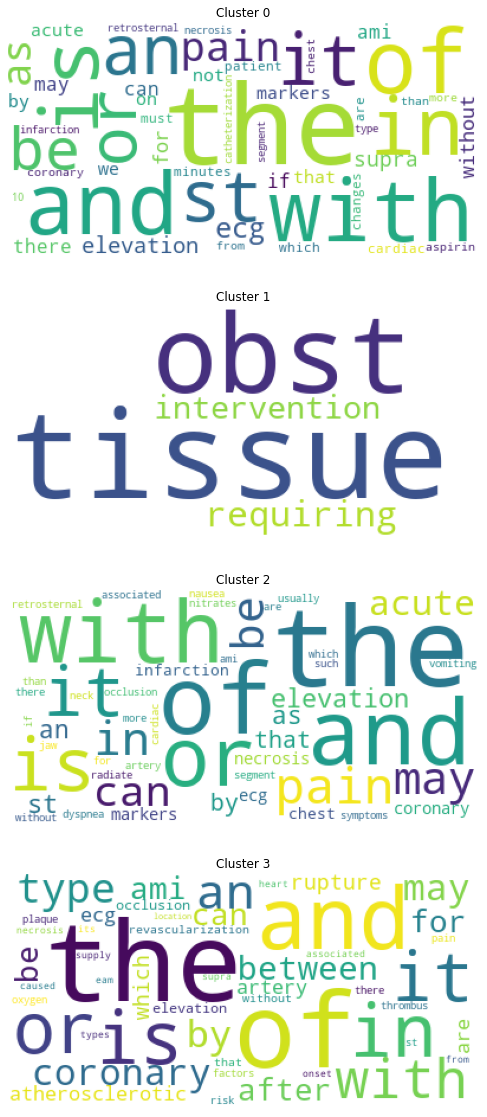

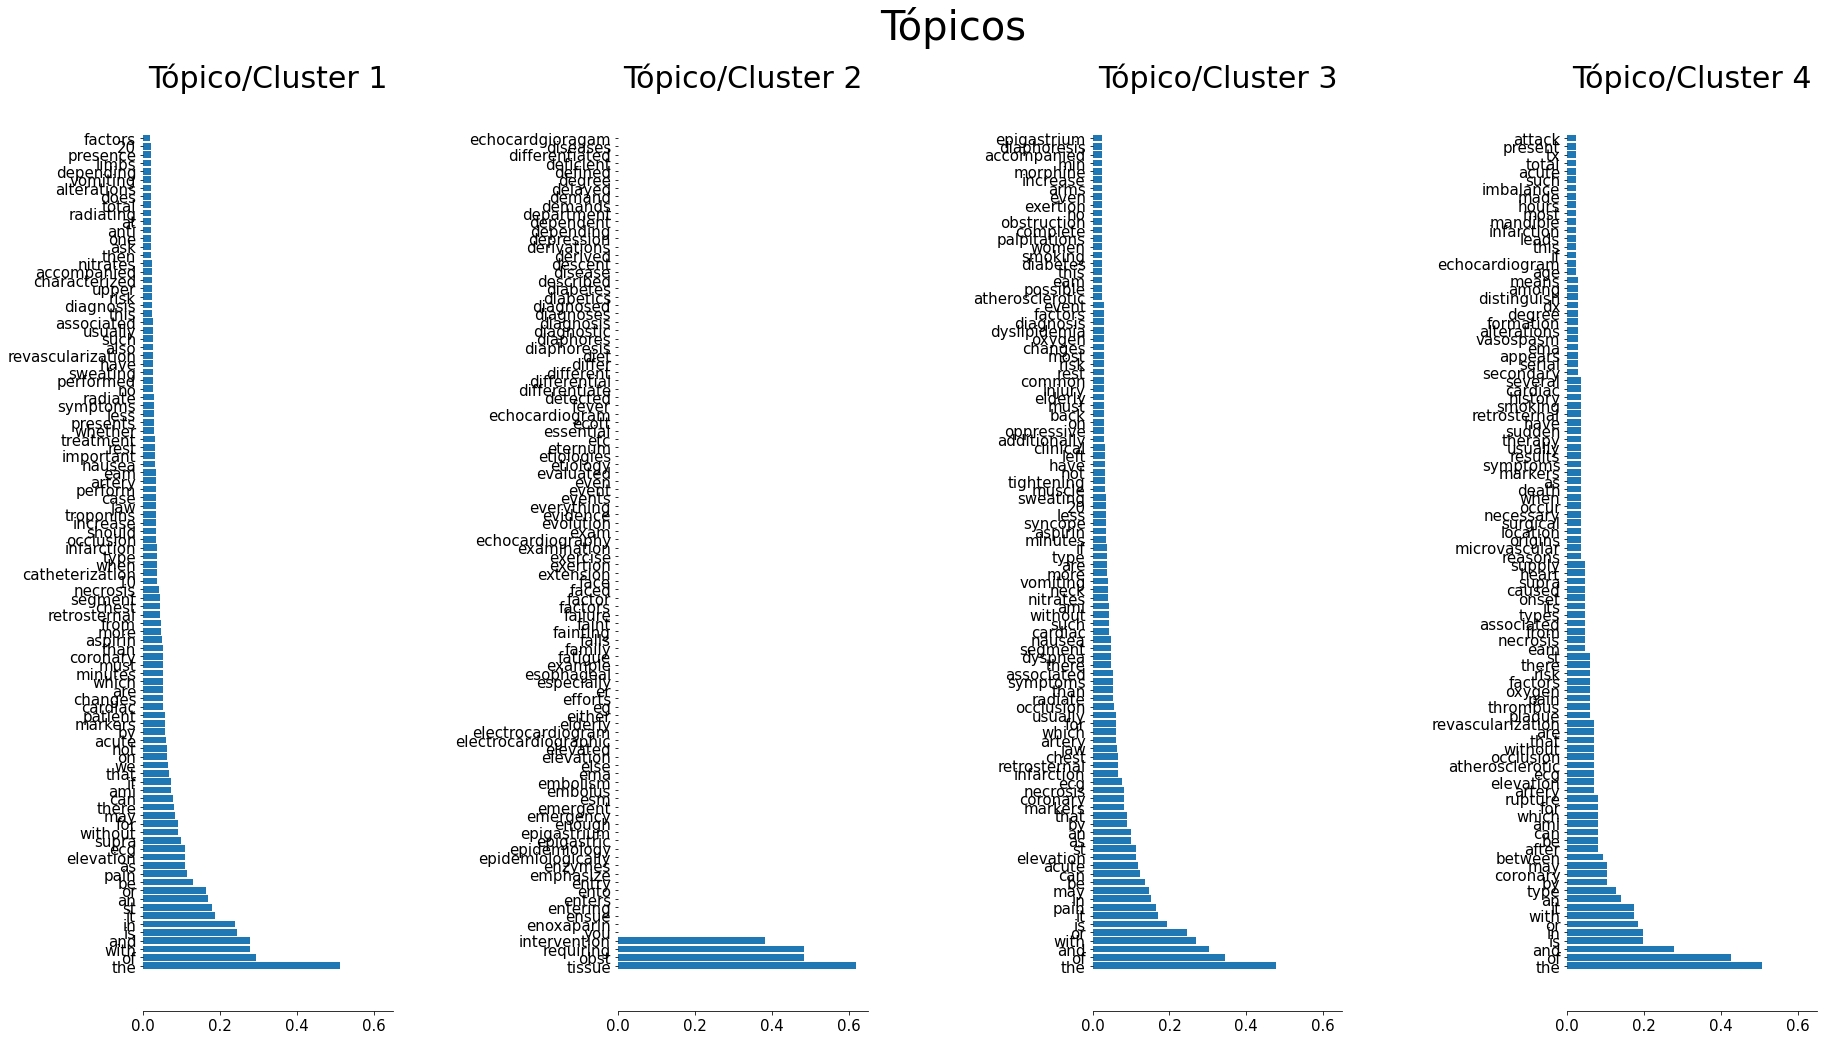

----------------------


AgglomerativeClustering(distance_threshold=8.5, n_clusters=None)
Quantidade de clusters resultantes:  5
Coerência:  0.3920158447235569
Coerência por Tópico:  [0.4857434221810306, 0.325071640486135, 0.38584128176816385, 0.3477964767478299, 0.41562640243462495]


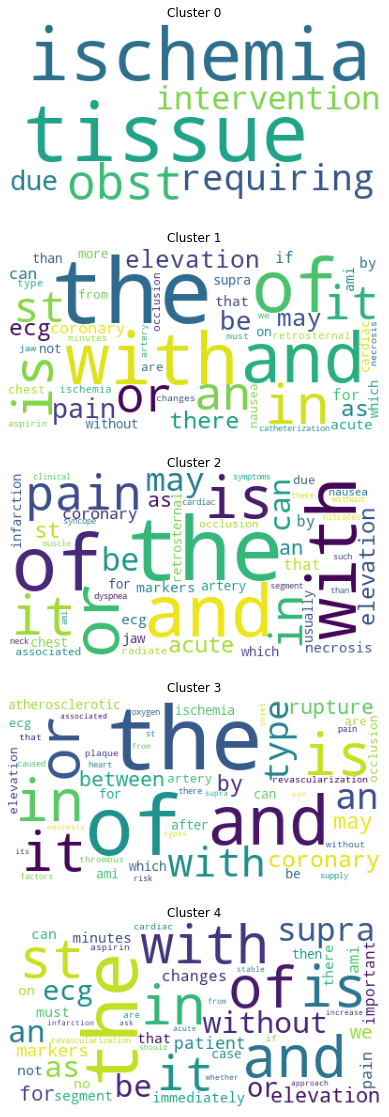

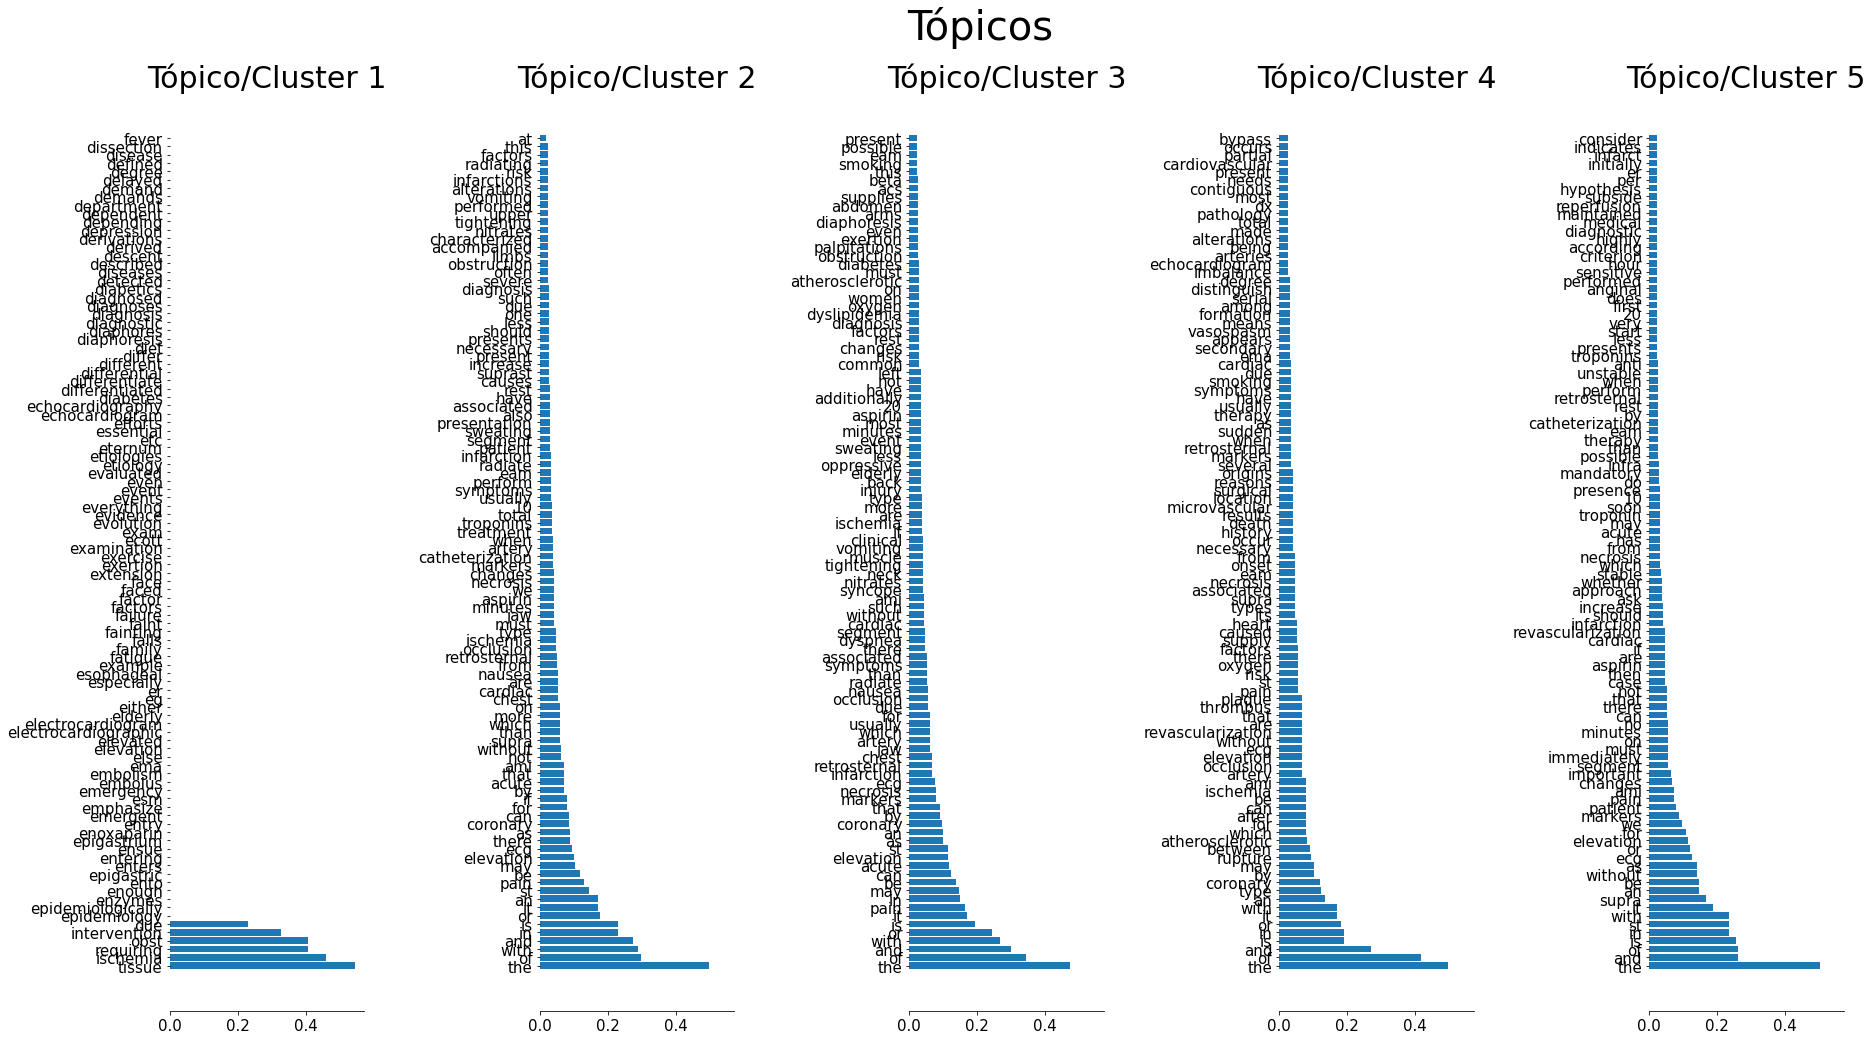

----------------------


AgglomerativeClustering(distance_threshold=3, n_clusters=None)
Quantidade de clusters resultantes:  24
Coerência:  0.5315170097083227
Coerência por Tópico:  [0.7572181654219162, 0.7469222564864143, 0.34709452243740807, 0.3768196466094853, 0.5363477715657534, 0.4957363512494662, 0.5416229233490908, 0.3152374672003331, 0.37847232485782095, 0.47303554069446413, 0.4337994730308859, 0.47866145089165235, 0.6581712442155129, 0.7124019881062541, 0.5373033848689726, 0.5478072254545547, 0.5182648069443894, 0.7055513394083861, 0.190494543868688, 0.4751755230280573, 0.5576654758522832, 0.6249957469449893, 0.643668762042811, 0.7039402984701567]


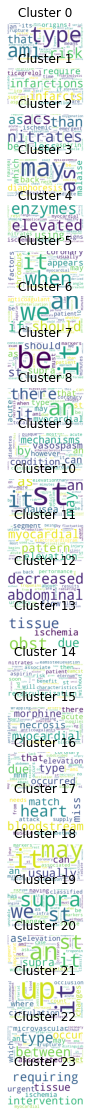

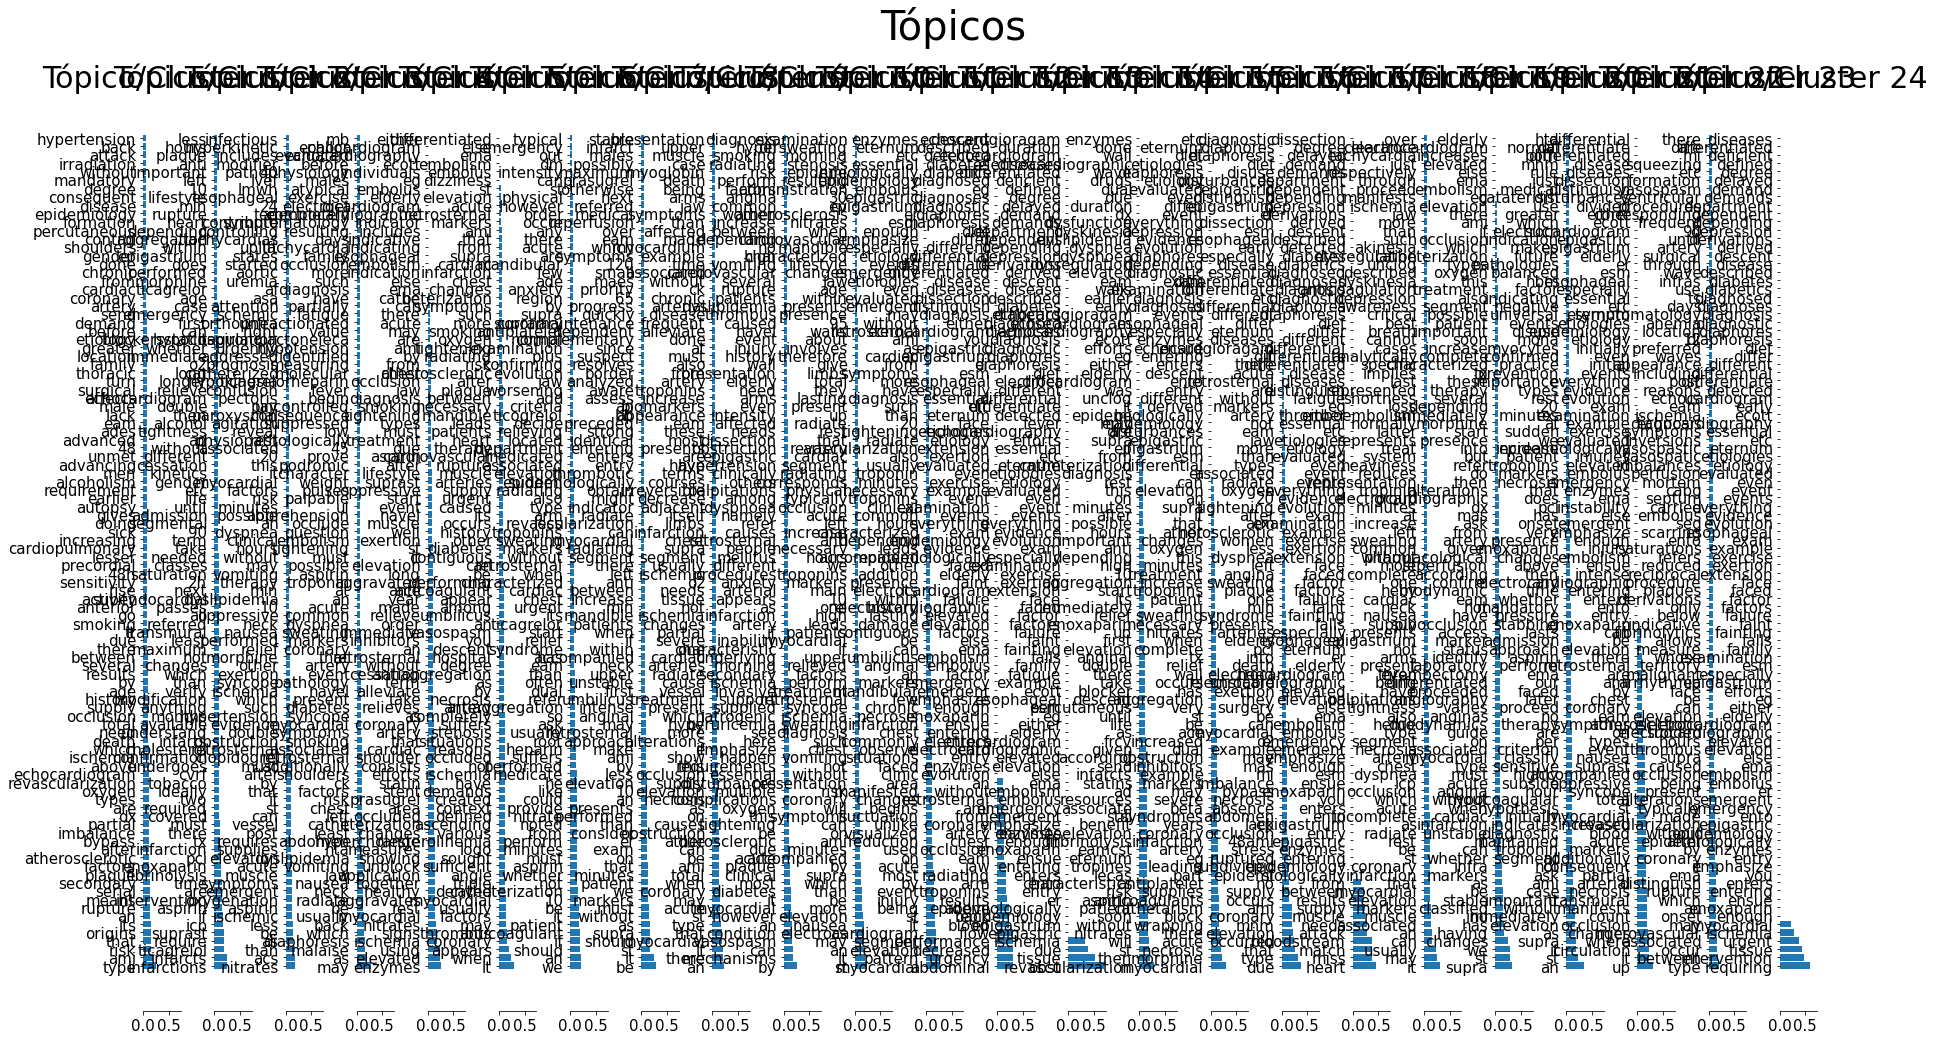

----------------------


AgglomerativeClustering(distance_threshold=1, n_clusters=None)
Quantidade de clusters resultantes:  79
Coerência:  0.6127080235242242
Coerência por Tópico:  [0.5648009499211423, 0.608011575056656, 0.5346043297593774, 0.6969535497346802, 0.5331963834301473, 0.5417468360887626, 0.6246605890104856, 0.663719006026352, 0.8048407541651731, 0.7025320869280798, 0.545211413652389, 0.596120716554486, 0.5616738873245938, 0.5757677235598754, 0.5765738575514269, 0.5595433211964128, 0.5257811095515139, 0.7023562615684762, 0.5421543480076031, 0.5597671802355196, 0.6720159477242253, 0.6207110514427343, 0.6403321070615303, 0.7661735690752332, 0.6957015877697263, 0.6135712731133305, 0.7236846342506795, 0.5554713449805461, 0.5585842370870359, 0.5610691158593725, 0.6425603973309133, 0.5502799060219384, 0.5899356131716688, 0.5733731263394712, 0.7054340863215072, 0.5398968946673263, 0.6307588748687274, 0.5266966906836097, 0.5665552843899211, 0.5487533011728393, 0.6431943788954306, 0

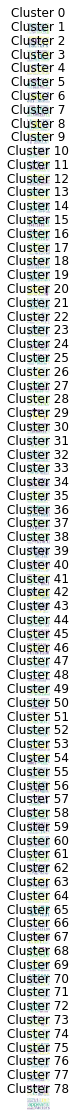

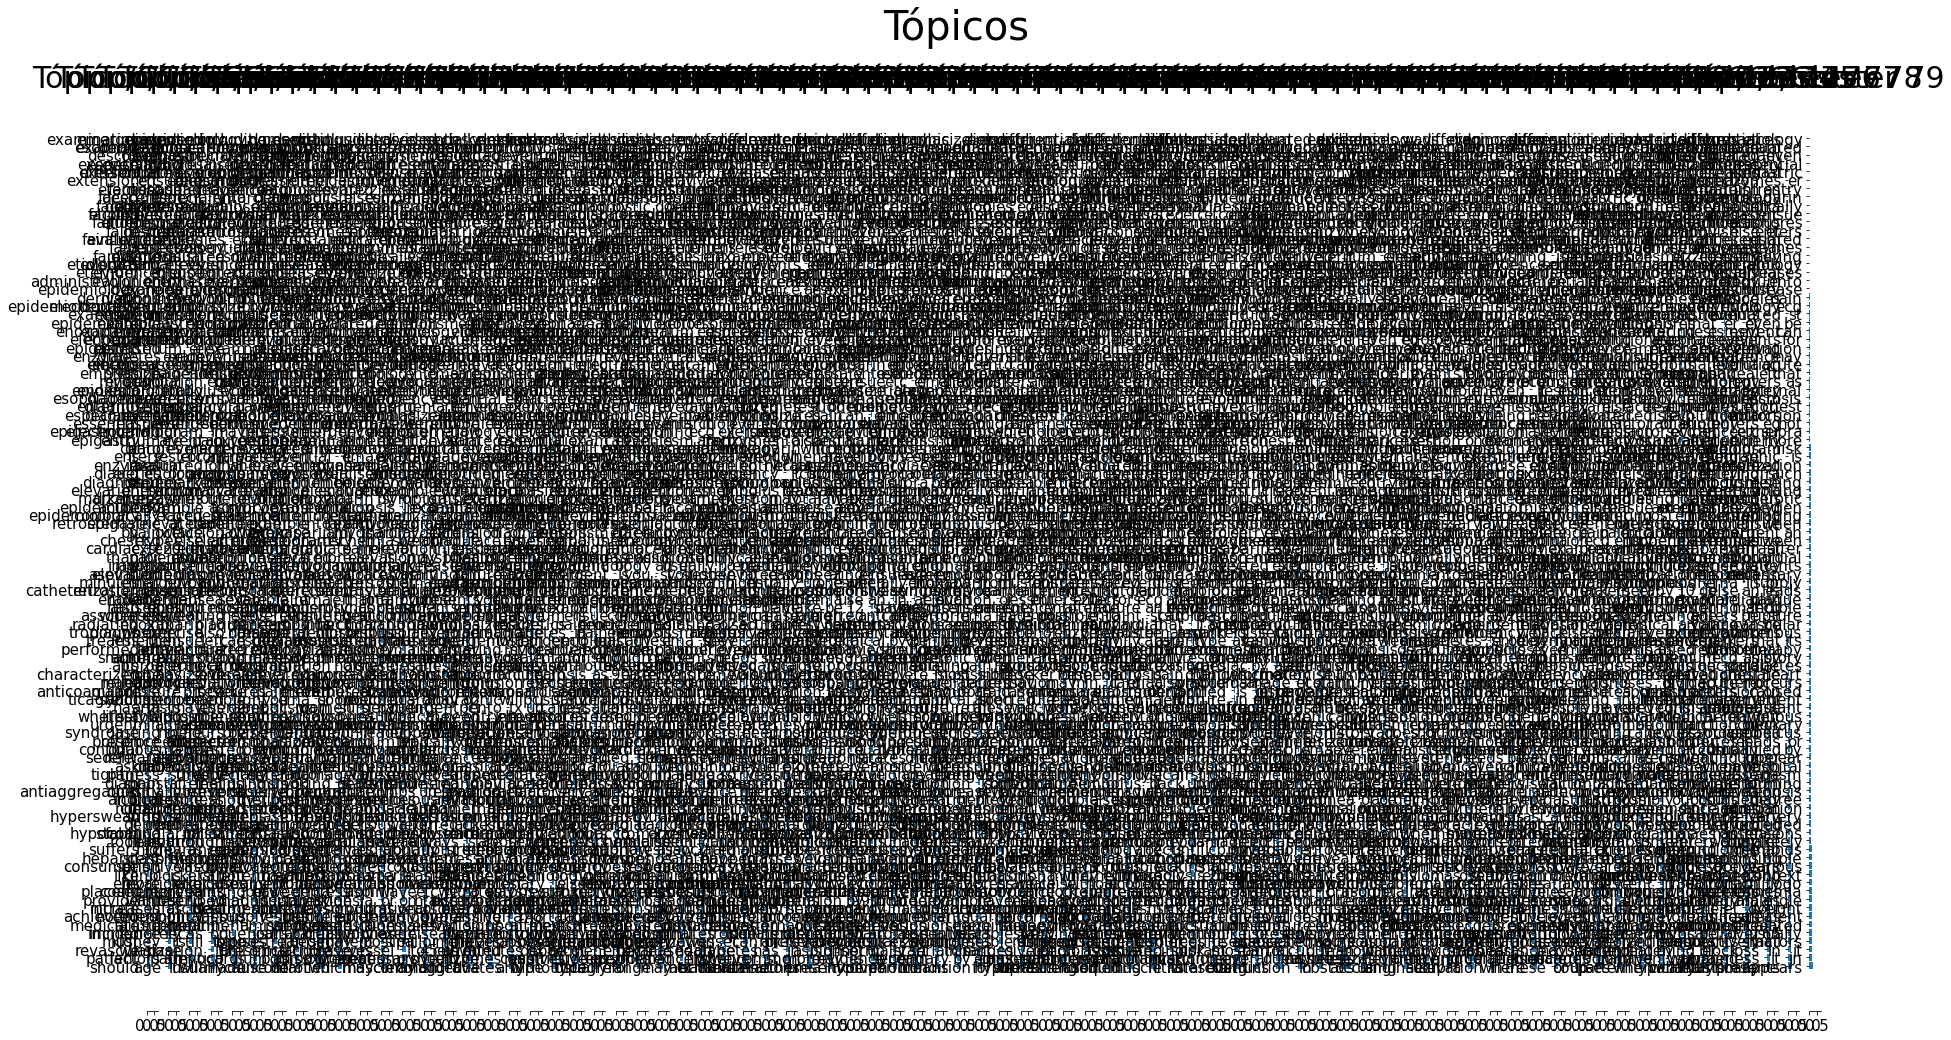

----------------------




In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS 
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from nltk.tokenize import RegexpTokenizer
    
tf_idf_vectorizer = TfidfVectorizer(max_df=0.8)
# tf_idf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.6)

k = 0

## Itera sobre cada resultado de uma clusterização
for n in n_clusters:
    # clusterings é uma lista de modelos de aglomeração hierárquica
    print(clusterings[k])
    print('Quantidade de clusters resultantes: ',n)

    clusters_as_documents = []
    clusters_as_documents_txt = [''] * n

    for i in range(len(sentences)):
        cluster_index = clusterings[k].labels_[i]
        sentence = sentences_numpy[i] + ' | '
        clusters_as_documents_txt[cluster_index] += sentence
    
    for document in clusters_as_documents_txt:
        clusters_as_documents.append(str(document).split('[')[1].replace('[', '').replace(']\n', '').replace('\'', ''))

    
    document_term_matrix = tf_idf_vectorizer.fit_transform(clusters_as_documents)
    terms = tf_idf_vectorizer.get_feature_names_out()
    terms_by_document = tf_idf_vectorizer.inverse_transform(document_term_matrix)
    tfidf_matrix = document_term_matrix.toarray()

    # print(document_term_matrix)
    # print(tfidf_matrix)
    
    top_terms_by_cluster = []
    top_tfidfs_by_cluster = []
    wordclouds = []

    ## Itera sobre cada documento (cluster) 
    for i in range(len(clusters_as_documents)):
        top_terms = []
        top_tfidfs = []
        
        ordered_tfidf = np.argsort(tfidf_matrix[i]) 
        top_tfidf_indexes = ordered_tfidf[-100:]
        #         top_tfidf_indexes = ordered_tfidf[-10:]
        
        for h in top_tfidf_indexes:
            top_terms.append(terms[h])
            top_tfidfs.append(tfidf_matrix[i][h])

        top_terms_by_cluster.append(top_terms)
        top_tfidfs_by_cluster.append(top_tfidfs)
        
        
        ## Criar WordCloud do Cluster
        dense = document_term_matrix[i].todense()
        lst1 = dense.tolist()
        tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

        wordcloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))
        wordclouds.append(wordcloud)

    ## Calcular Coerência dos Tópicos
    dictionary = Dictionary(terms_by_document)
    corpus = [dictionary.doc2bow(text) for text in terms_by_document]
    texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus]
    cm = CoherenceModel(topics=top_terms_by_cluster, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', topn=100)

    print('Coerência: ',cm.get_coherence())
    print('Coerência por Tópico: ',cm.get_coherence_per_topic())
    #     print(top_terms_by_cluster)    
    
        
        
    ## Plotar Nuvens de Palavras de cada cluster
    fig, axs = plt.subplots(n, figsize=(10, 20))
    j=0

    for wc in wordclouds:
        axs[j].title.set_text('Cluster '+str(j))
        axs[j].imshow(wc)
        axs[j].axis("off")
        j+=1
   
    ## Plotar gráfico de barras com os termos mais relevantes de cada cluster
    fig, axes = plt.subplots(1, len(top_terms_by_cluster), figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for i in range(len(top_terms_by_cluster)):
        ax = axes[i]
#         print(top_terms_by_cluster[i])
        ax.barh(top_terms_by_cluster[i], top_tfidfs_by_cluster[i])
        ax.set_title(f"Tópico/Cluster {i +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Tópicos', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    plt.savefig(IMG_OUTPUT_PATH + 'distributions_of_' + str(n) + '.jpg')
    plt.show()
    
#     plt.savefig(IMG_OUTPUT_PATH + 'topicos_por_'+str(n)+'_clusters.jpg')
#     plt.show()

    k+=1
    print('----------------------\n\n')